# 1. Planning optimizer module

## Import des librairies et définition des paramètres de planification :

On cherche à optimiser le planning entre DATE_DEBUT et DATE_FIN

on donne un nom d'utilisateur et un id

On précise les fichiers de plage horaire, d'impératifs et les tâches de l'utilisateur :

In [49]:
import pandas as pd
from module import Planning

DATE_DEBUT = '2020-05-11 08:30:00'
DATE_FIN   = '2020-05-15 18:00:00'

data_example_path = 'data_example/'
plagehoraire_filename = "exemple_horaires.json"
tasks_filename        = "exemple_tâches.json"
imperatifs_filename   = "exemple_impératifs.json"

## Horaires de travail :

In [50]:
pd.read_json(data_example_path +plagehoraire_filename)

,Nom,Jour,Heure début,Heure fin
0,0,0,08:00:00,12:00:00
1,1,0,13:00:00,17:00:00
2,2,1,08:00:00,12:00:00
3,3,1,13:00:00,17:00:00
4,4,2,08:00:00,12:00:00
5,5,2,13:00:00,17:00:00
6,6,3,08:00:00,12:00:00
7,7,3,13:00:00,17:00:00
8,8,4,08:00:00,12:00:00
9,9,4,13:00:00,17:00:00


## Tâches à optimiser :

In [51]:
pd.read_json(data_example_path +tasks_filename)

,id tache,Objet,Durée,Priorité
0,0,Perrot Sébastien | Vacances | TEAMBER (2018-51),1.75,3
1,1,BADETS Claude | RE: Teamber | OTCE GROUPE (201...,3.00,7
2,2,SAULIERES Vincent | TR: EIFFAGE ROUTE / Cahier...,1.00,13
3,3,R2M | Préparer les imports | R2M (2018-90),1.75,5
4,4,BADETS Claude | Bilan_Financier.xls | OTCE GRO...,1.00,10
5,5,ZANON Stéphane | Formation dernière demi-journ...,3.00,14
6,6,TEAMBER | Travail sur structure BD | TEAMBER V...,2.50,18
7,7,TEAMBER | rdv chez elle avec Jean-Luc | PROPRI...,3.00,16
8,8,Perrot Sébastien | Rdv cardiologue | SNCF (201...,2.50,9
9,9,TEAMBER | - | TEAMBER V2 (2019-000066),1.75,21


## Impératifs :

In [52]:
d = pd.read_json(data_example_path + imperatifs_filename)
d['Date début'] = pd.to_datetime(d['Date début'],unit='ms')
d['Date fin'] = pd.to_datetime(d['Date fin'],unit='ms')
d

,Objet,Priorité,Date début,Date fin
0,Rdv DENTISTE,IMPERATIF,2020-05-12 10:00:00,2020-05-12 11:00:00
1,Accueil nouvelle recrue,IMPERATIF,2020-05-13 09:30:00,2020-05-13 11:30:00
2,Rdv Expert Comptable,IMPERATIF,2020-05-14 09:00:00,2020-05-14 10:00:00
3,Rdv Banque,IMPERATIF,2020-05-15 14:00:00,2020-05-15 16:00:00
4,Réserver les vacances d'été,IMPERATIF,2020-05-17 16:00:00,2020-05-17 18:00:00
5,Restaurant avec l'équipe,IMPERATIF,2020-05-20 12:00:00,2020-05-20 12:50:00
6,Footing,IMPERATIF,2020-05-22 08:00:00,2020-05-22 09:00:00


## On créé un objet de Planning sur lequel on va pouvoir travailler.

On découpe également les tâches à planifier en morceaux de tâches de maximum 1 (ou autre durée) heure avec la fonction split_tasks.

Remarque : plus on choisie une durée maximale faible, plus il y aura de morceaux et donc plus l'optimisation prendra du temps (linéaire en nombre de morceaux). On pourra mieux combler les trous de l'emploi du temps, ainsi moins de temps sera perdu.
Mais il se peut que l'on perde en continuité dans le travail, c'est à dire que pour réaliser une tâche, on s'y reprendra plus problament plusieurs fois dans la période de sprint.

In [53]:
# json files inputs :
plagehoraire = pd.read_json(data_example_path + "exemple_horaires.json").to_json()
tasks = pd.read_json(data_example_path + "exemple_tâches.json").to_json()
imperatifs = pd.read_json(data_example_path + "exemple_impératifs.json").to_json()

In [54]:
plagehoraire

'{"Nom":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9},"Jour":{"0":0,"1":0,"2":1,"3":1,"4":2,"5":2,"6":3,"7":3,"8":4,"9":4},"Heure d\\u00e9but":{"0":"08:00:00","1":"13:00:00","2":"08:00:00","3":"13:00:00","4":"08:00:00","5":"13:00:00","6":"08:00:00","7":"13:00:00","8":"08:00:00","9":"13:00:00"},"Heure fin":{"0":"12:00:00","1":"17:00:00","2":"12:00:00","3":"17:00:00","4":"12:00:00","5":"17:00:00","6":"12:00:00","7":"17:00:00","8":"12:00:00","9":"17:00:00"}}'

In [55]:
p = Planning(
    plagehoraire,
    tasks,
    imperatifs,
    DATE_DEBUT,
    DATE_FIN
)

C:\Users\antoi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## On peut voir que compte tenu des horaires de travail, des impératifs de l'utilisateur, de la période indiquée de sprint, le programme a su déterminer quand l'utilisateur était disposé à réaliser les tâches

In [56]:
p.base

,index,Date début,Date fin,Longueur,Temps écoulé
0,0,2020-05-11 08:30:00,2020-05-11 12:00:00,3.5,0.0
1,1,2020-05-11 13:00:00,2020-05-11 17:00:00,4.0,4.5
2,2,2020-05-12 08:00:00,2020-05-12 10:00:00,2.0,23.5
3,3,2020-05-12 11:00:00,2020-05-12 12:00:00,1.0,23.5
4,4,2020-05-12 13:00:00,2020-05-12 17:00:00,4.0,28.5
5,5,2020-05-13 08:00:00,2020-05-13 09:30:00,1.5,47.5
6,6,2020-05-13 11:30:00,2020-05-13 12:00:00,0.5,47.5
7,7,2020-05-13 13:00:00,2020-05-13 17:00:00,4.0,52.5
8,8,2020-05-14 08:00:00,2020-05-14 09:00:00,1.0,71.5
9,9,2020-05-14 10:00:00,2020-05-14 12:00:00,2.0,71.5


## On peut changer les pénalités de ce planning afin de changer la façon de l'optimiser, explication :

les pénalités de l'utilisateur $(a,b,c)$  sont telles que $0 < a, b, c$ et $a + b + c = 1$.

- $a$ correspond à la pénalité sur le temps perdu. Si (a,b,c) = (1,0,0) on va minimiser uniquement le temps perdu
- $b$ correspond à la pénalité sur le non respect des priorités. Si (a,b,c) = (0,1,0), le seul objectif sera de respecter les priorités lors de l'optimisation.
- $c$ correspond à la pénalité sur la dispersion d'une tâche. Si (a,b,c) = (0,0,1), le seul objectif sera de faire les tâches en une seule fois. On rappelle que les tâches sont découper en morceaux n'excédant pas une durée maximale.

Par défaut, $(a,b,c)=(1/6,2/3,1/6)$ qui fait un peu tout à la fois, mais dans la cellule suivante on montre comment changer ces réglages :

Remarque : pas obligé de refléchir à ce que $a+b+c=1$, le programme le fait tout seul.

In [57]:
p.set_penalties([1,4,1])

## Avant l'optimisation, observons les scores :

In [58]:
p.show_scores()

Pourcentage temps perdu : 4.10%
Non respect priorités : 33.75%
Score dispersion : 0.00%


## Dans la cellule suivante, on lance l'optimisation du planning :

Plus l'énergie totale est proche de 0, plus l'emploi du temps est bon.

On peut voir les graphes en précisant show=True

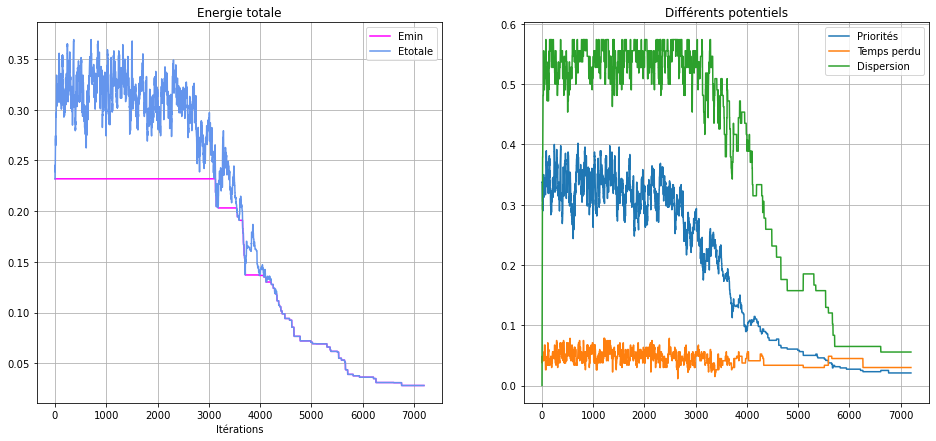

In [59]:
p.optimize(show=True)

## Résultat : le planning est optimisé

In [60]:
p.make_planning()

,Objet,Priorité,Date début,Date fin
0,LABSOFT | test | DEVELOPPEMENT (2015-1),0,2020-05-11 08:30:00,2020-05-11 11:00:00
1,GARCIA INGENIERIE | RE: TABLEAU DE BORD FACTU ...,4,2020-05-11 11:00:00,2020-05-11 12:00:00
2,GARCIA INGENIERIE | RE: TABLEAU DE BORD FACTU ...,4,2020-05-11 13:00:00,2020-05-11 13:45:00
3,Perrot Sébastien | Vacances | TEAMBER (2018-51),3,2020-05-11 13:45:00,2020-05-11 15:30:00
4,R2M | Préparer les imports | R2M (2018-90),5,2020-05-11 15:30:00,2020-05-11 16:15:00
5,R2M | Préparer les imports | R2M (2018-90),5,2020-05-12 08:00:00,2020-05-12 09:00:00
6,BADETS Claude | RE: Teamber | OTCE GROUPE (201...,7,2020-05-12 09:00:00,2020-05-12 10:00:00
7,Rdv DENTISTE,IMPERATIF,2020-05-12 10:00:00,2020-05-12 11:00:00
8,BADETS Claude | RE: Teamber | OTCE GROUPE (201...,7,2020-05-12 11:00:00,2020-05-12 12:00:00
9,TEAMBER | Spécifications | TEAMBER V2 (2019-00...,6,2020-05-12 13:00:00,2020-05-12 14:45:00


## Après optimisation, observons les scores des différents indicateurs :

In [61]:
p.show_scores()

Pourcentage temps perdu : 2.99%
Non respect priorités : 2.08%
Score dispersion : 5.56%


## Si certaines tâches n'ont pas pu être planifiées en raison d'un manque de temps sur la période choisie elles se retrouvent ici :

In [62]:
p.not_scheduled()

,id tache,Objet,Durée,Priorité
id morceau,,,,
15,7,TEAMBER | rdv chez elle avec Jean-Luc | PROPRI...,1.00,16
33,14,Semeteys Cécile | RE: Cloud Ectare | CABINET E...,1.00,15
34,14,Semeteys Cécile | RE: Cloud Ectare | CABINET E...,0.75,15
14,6,TEAMBER | Travail sur structure BD | TEAMBER V...,0.50,18
12,6,TEAMBER | Travail sur structure BD | TEAMBER V...,1.00,18
13,6,TEAMBER | Travail sur structure BD | TEAMBER V...,1.00,18
35,15,KOWALSKI Jean-François | Réunion téléphonique ...,1.00,19
36,15,KOWALSKI Jean-François | Réunion téléphonique ...,0.75,19
25,11,KOWALSKI Jean-François | Faire des tests | VER...,1.00,20


# 2. Plannification de tâches multi-utilisateurs TO DO

In [4]:
from multi_user_module import *

demo_data_path = 'multi_user_demo_data/'

group_file = demo_data_path + 'exemple_groupe_de_travail.xlsx'   #choix de l'équipe
TMF_file   = demo_data_path + 'exemple_TMF.json'                 #fichier contenant les tâches à planifier

DATE_DEBUT = '2020-05-11 08:30:00'              #date de début du sprint
DATE_FIN   = '2020-05-16 18:00:00'              #date de fin du sprint

## On importe le groupe dont on va planifier les tâches mère-fille :

In [43]:
group = pd.read_json(group_file)
group

,ID,Nom,Prénom,Fichier Horaires,Fichier Impératifs
0,0,Dumont,David,multi_user_demo_data/exemple_horaires.json,multi_user_demo_data/exemple_impératifs.json
1,1,Bertrand,David,multi_user_demo_data/exemple_horaires.json,multi_user_demo_data/exemple_impératifs.json
2,2,Gerard,Anne,multi_user_demo_data/exemple_horaires.json,multi_user_demo_data/exemple_impératifs.json
3,3,Mathieu,Christophe,multi_user_demo_data/exemple_horaires.json,multi_user_demo_data/exemple_impératifs.json
4,4,Durand,Eric,multi_user_demo_data/exemple_horaires.json,multi_user_demo_data/exemple_impératifs.json


## Visualisation des tâches à planifier :

In [46]:
TMF = pd.read_json(TMF_file)
TMF

,id tache,Objet,Durée,id utilisateur,Next tache id,Prev tache id
0,0,tache 0,0.25,2,1,-1
1,1,tache 1,3.00,3,2,0
2,2,tache 2,3.00,3,3,1
3,3,tache 3,1.00,2,4,2
4,4,tache 4,2.50,4,5,3
5,5,tache 5,1.00,0,6,4
6,6,tache 6,1.75,3,7,5
7,7,tache 7,1.00,1,8,6
8,8,tache 8,1.75,0,9,7
9,9,tache 9,3.00,0,10,8


## Visualisation impératifs (identiques pour tous les utilisateurs) :

In [48]:
d = pd.read_json(demo_data_path + 'exemple_impératifs.json')
d['Date début'] = pd.to_datetime(d['Date début'],unit='ms')
d['Date fin'] = pd.to_datetime(d['Date fin'],unit='ms')
d

,Objet,Priorité,Date début,Date fin
0,Rdv DENTISTE,IMPERATIF,2020-05-12 10:00:00,2020-05-12 11:00:00
1,Accueil nouvelle recrue,IMPERATIF,2020-05-13 09:30:00,2020-05-13 11:30:00
2,Rdv Expert Comptable,IMPERATIF,2020-05-14 09:00:00,2020-05-14 10:00:00
3,Rdv Banque,IMPERATIF,2020-05-15 14:00:00,2020-05-15 16:00:00
4,Réserver les vacances d'été,IMPERATIF,2020-05-17 16:00:00,2020-05-17 18:00:00
5,Restaurant avec l'équipe,IMPERATIF,2020-05-20 12:00:00,2020-05-20 12:50:00
6,Footing,IMPERATIF,2020-05-22 08:00:00,2020-05-22 09:00:00


## Planification des tâches :

In [ ]:
planned_TMF = planifieTMF(TMF, DATE_DEBUT, DATE_FIN, plannings, maxiter = 1500)